In [4]:
import pandas as pd
import ast
from joblib import Parallel, delayed
from tqdm.notebook import tqdm  # progress bar in Colab
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    BitsAndBytesConfig,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq
)
from peft import LoraConfig, get_peft_model



In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# import pandas as pd

# file_path = "/content/drive/MyDrive/train.csv"
# df = pd.read_csv(file_path)

file_path = "/kaggle/input/trainset/train.csv"
df = pd.read_csv(file_path)

In [7]:
df.head()

,instruction,input,output,prompt
0,Create a function to calculate the sum of a se...,"[1, 2, 3, 4, 5]",# Python code\ndef sum_sequence(sequence):\n ...,Below is an instruction that describes a task....
1,Generate a Python code for crawling a website ...,website: www.example.com \ndata to crawl: phon...,import requests\nimport re\n\ndef crawl_websit...,Below is an instruction that describes a task....
2,Create a Python list comprehension to get the ...,NaN,"[x*x for x in [1, 2, 3, 5, 8, 13]]",Below is an instruction that describes a task....
3,Generate a python script to perform this action.,"Given a string, remove all the consecutive dup...",def remove_duplicates(string): \n result = ...,Below is an instruction that describes a task....
4,Write a python script to generates random numb...,NaN,def generate_random_divisible_number():\n i...,Below is an instruction that describes a task....


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18612 entries, 0 to 18611
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instruction  18612 non-null  object
 1   input        12866 non-null  object
 2   output       18612 non-null  object
 3   prompt       18612 non-null  object
dtypes: object(4)
memory usage: 581.8+ KB


In [9]:
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

Dataset shape: (18612, 4)
Columns: ['instruction', 'input', 'output', 'prompt']


In [10]:
df["instruction_len"] = df["instruction"].astype(str).apply(len)
df["output_len"] = df["output"].astype(str).apply(len)

print("\nInstruction length stats:\n", df["instruction_len"].describe())
print("\nOutput length stats:\n", df["output_len"].describe())



Instruction length stats:
 count    18612.000000
mean        98.189018
std        109.796379
min         21.000000
25%         68.000000
50%         83.000000
75%        103.000000
max       7755.000000
Name: instruction_len, dtype: float64

Output length stats:
 count    18612.000000
mean       465.976306
std       1112.515015
min          1.000000
25%        149.000000
50%        260.000000
75%        444.000000
max      20779.000000
Name: output_len, dtype: float64


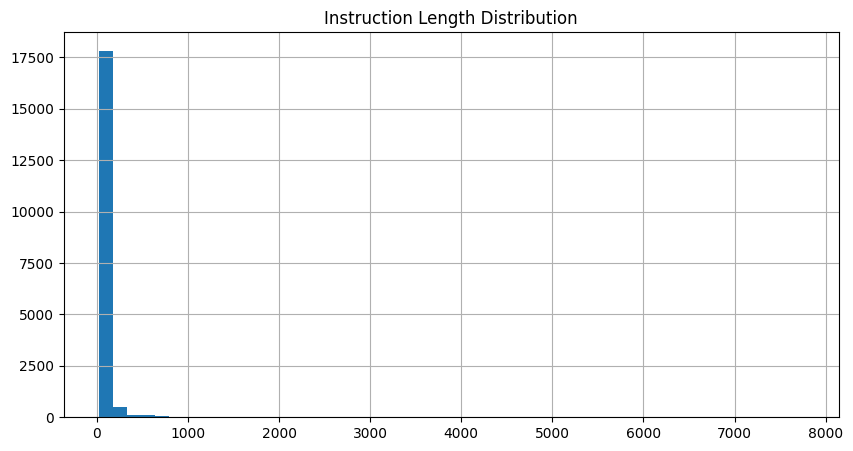

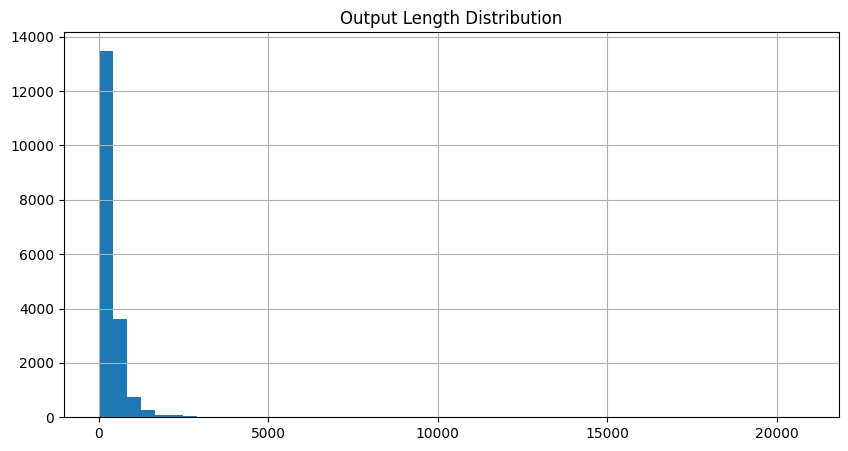

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
df["instruction_len"].hist(bins=50)
plt.title("Instruction Length Distribution")
plt.show()

plt.figure(figsize=(10,5))
df["output_len"].hist(bins=50)
plt.title("Output Length Distribution")
plt.show()


In [12]:
print("Number of nulls per column:")
print(df.isnull().sum())

print("\nNumber of duplicate rows:")
print(df.duplicated().sum())


Number of nulls per column:
instruction           0
input              5746
output                0
prompt                0
instruction_len       0
output_len            0
dtype: int64

Number of duplicate rows:
0


In [ ]:
import pandas as pd


col = df['output']

text_length = col.str.len()


Q1 = text_length.quantile(0.25)
Q3 = text_length.quantile(0.75)
IQR = Q3 - Q1


outliers = col[(text_length < Q1 - 1.5 * IQR) | (text_length > Q3 + 1.5 * IQR)]

print(f"Number of outlier texts: {len(outliers)}")
print(outliers.head())


Number of outlier texts: 1356
6     from flask import Flask, request\nfrom flask_s...
15    import numpy as np\nimport keras\nfrom keras.l...
28    def solve_sudoku(board): \n  \n    # Utility f...
43    class TicTacToe:\n\ndef __init__(self):\n    s...
48    import random\n\ndef generateMarkov(text):\n  ...
Name: output, dtype: object


In [14]:
!pip install black


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.8 MB/s eta 0:00:0000:0100:01


In [15]:
import pandas as pd
import ast


def detect_code_type(code: str) -> str:
    try:
        ast.parse(code)
        return "Valid Python"
    except IndentationError:
        return "Python Indentation Error"
    except SyntaxError:
        return "Python Syntax Error"
    except Exception:
        return "Not Python"

df["code_status"] = df["output"].apply(detect_code_type)


print(df["code_status"].value_counts())


code_status
Valid Python                16393
Python Indentation Error     1257
Python Syntax Error           962
Name: count, dtype: int64


In [16]:
import pandas as pd
import parso
from black import format_str, FileMode



def fix_code_dynamic(code: str) -> str:
    """
    Try to dynamically fix Python code:
    1. Parse with parso to detect syntax/indentation errors.
    2. Reformat with black for consistent indentation and spacing.
    """
    try:
        # Step 1: parse the code with parso to detect errors
        tree = parso.parse(code)

        # Step 2: reformat using black
        fixed_code = format_str(code, mode=FileMode())
        return fixed_code
    except Exception:
        # If parsing/formatting fails, return original code
        return code

# Update the same column 'output' with fixed code
df["output"] = df["output"].apply(fix_code_dynamic)

df["output"].head()

0    # Python code\ndef sum_sequence(sequence):\n  ...
1    import requests\nimport re\n\n\ndef crawl_webs...
2               [x * x for x in [1, 2, 3, 5, 8, 13]]\n
3    def remove_duplicates(string):\n    result = "...
4    def generate_random_divisible_number():\n    i...
Name: output, dtype: object

In [17]:
import pandas as pd
import ast


def detect_code_type(code: str) -> str:
    try:
        ast.parse(code)
        return "Valid Python"
    except IndentationError:
        return "Python Indentation Error"
    except SyntaxError:
        return "Python Syntax Error"
    except Exception:
        return "Not Python"

df["code_status"] = df["output"].apply(detect_code_type)


print(df["code_status"].value_counts())


code_status
Valid Python                16402
Python Indentation Error     1250
Python Syntax Error           960
Name: count, dtype: int64


In [18]:
def get_non_ascii_chars(text):
    return [ch for ch in str(text) if ord(ch) > 127]

for col in ["instruction", "input", "output"]:
    unique_chars = set()
    df[col].dropna().apply(lambda x: unique_chars.update(get_non_ascii_chars(x)))
    print(f"Unique non-ASCII characters in column '{col}':")
    print(unique_chars)
    print("------")


Unique non-ASCII characters in column 'instruction':
{'⅓', '𝐱', 'π', '\u200a', '²', 'ⅇ', '≥', 'ï', '기', '−', '–', 'í', '’', '→', '͏', '…', '‘', '”', '경', '𝑧', '—', '𝑦', '“', '½', '𝑥', '•', '∈', 'ó', '≤', '°'}
------
Unique non-ASCII characters in column 'input':
{'²', '≥', '：', '−', '–', '’', 'И', '°', 'ñ', '→', 'Й', '¢', '‘', '£', '”', '€', 'ç', 'Ω', 'Τ', '“', 'Ю', '\xa0', 'ó', '≤', 'Θ', '×'}
------
Unique non-ASCII characters in column 'output':
{'每', '杀', '词', '部', '로', '设', 'Т', '와', '키', 'П', '끝', 'И', '文', '效', '진', '👋', 'з', '印', '去', '确', '白', '핸', '“', '于', '名', '从', '등', '수', '널', '大', '데', '端', '思', '題', '강', '真', '近', '않', '及', '密', '인', '알', '客', '出', '광', '发', '¢', '称', '완', '\ufeff', '㎍', '경', '开', '观', '化', '섹', '으', '法', '측', 'в', '스', '查', '일', '信', '所', '된', '好', '得', '目', '持', '再', '공', '的', '放', '差', '담', '存', '안', '源', '类', '§', '标', '话', '야', '용', '暂', 'Τ', '中', '算', 'л', '발', '것', 'Ю', '置', 'Ü', 'ř', '×', '先', '选', '能', '返', '능', '고', '照', '总', '闭', '산', 'é', '에

In [19]:
import unicodedata

def normalize_text(text):
    if pd.isna(text):
        return text

    text = text.replace("“", '"').replace("”", '"')
    text = text.replace("‘", "'").replace("’", "'")

    text = text.replace("–", "-").replace("—", "-").replace("−", "-")


    text = text.replace("\u00A0", " ")  # non-breaking space

    text = unicodedata.normalize("NFKC", text)

    return text


for col in ["instruction", "input", "output"]:
    df[col] = df[col].astype(str).apply(normalize_text)


In [20]:
import re
import pandas as pd

# Allowed characters (math, programming, and special symbols to keep)
allowed_chars = set([
    '≤', '≥', '→', 'π', '²', '³', '½', '⅓', '¼', '¾',  # Math symbols
    '−', '-', '+', '=', '*', '/', '×', '^', '%',       # Operators
    '°',                                               # Degree
    '∈', '∞',                                          # Advanced math
    '(', ')', '[', ']', '{', '}',                      # Brackets
    '.', ',', ':', ';',                                # Punctuation
])

def clean_text(text):
    """Remove unwanted characters and keep only ASCII or allowed math/code symbols"""
    if pd.isna(text):
        return text
    return "".join(ch for ch in text if ch.isascii() or ch in allowed_chars)

# Apply cleaning to specific columns directly in df
for col in ["instruction", "input", "output"]:
    df[col] = df[col].apply(clean_text)

print("✅ Data cleaned and updated in the same DataFrame")


✅ Data cleaned and updated in the same DataFrame


In [21]:
def get_non_ascii_chars(text):
    return [ch for ch in str(text) if ord(ch) > 127]

for col in ["instruction", "input", "output"]:
    unique_chars = set()
    df[col].dropna().apply(lambda x: unique_chars.update(get_non_ascii_chars(x)))
    print(f"Unique non-ASCII characters in column '{col}':")
    print(unique_chars)
    print("------")


Unique non-ASCII characters in column 'instruction':
{'π', '≥', '∈', '→', '≤', '°'}
------
Unique non-ASCII characters in column 'input':
{'°', '≥', '→', '≤', '×'}
------
Unique non-ASCII characters in column 'output':
{'×', '°', '→'}
------


In [22]:
print("Number of nulls per column:")
print(df.isnull().sum())

print("\nNumber of duplicate rows:")
print(df.duplicated().sum())


Number of nulls per column:
instruction        0
input              0
output             0
prompt             0
instruction_len    0
output_len         0
code_status        0
dtype: int64

Number of duplicate rows:
0


In [23]:
# Explore instruction column
print("Unique instructions:", df["instruction"].nunique())
print("\nExamples from instruction column:\n")
print(df["instruction"].sample(10).values)


Unique instructions: 18576

Examples from instruction column:

['Write a Python function to take a list of words and return a dictionary of word counts.'
 'Create a class in Python that represents a vector in a 3-dimensional space.'
 'Create a Python script which inputs a sentence and performs POS tagging and letter count for the text using NLTK library.'
 'Write a Python program to create and print a list of the first 10 prime numbers.'
 'Create a program that uses Django and Python to display a list of books.'
 'Translate a given python program into a mips assembly instruction.'
 'Design a Python algorithm to find the largest element in a list.'
 'Create a Python program to construct a Huffman tree from the given input string.'
 "Given a list of integers, write a Python program to find the list's maximum value."
 'Construct a Python program for extracting multiple values from a nested dictionary.']


In [24]:
# Explore input column
print("Unique inputs:", df["input"].nunique())
print("\nExamples from input column:\n")
print(df["input"].dropna().sample(10).values)


Unique inputs: 9532

Examples from input column:

['numbers = [2, 8, 10]\ndivisor = 2' 'nan' 'str1 = "abcd"\nstr2 = "cbda"'
 '5' 'Input URL: https://en.wikipedia.org/wiki/Web_scraping' 'nan'
 'Not applicable' 'x1 = [1 ,2 ,3, 4, 5]\ny = [1, 2, 1, 2, 1]' 'nan' 'nan']


In [25]:
# Explore output column
print("Unique outputs:", df["output"].nunique())
print("\nExamples from output column:\n")
print(df["output"].sample(10).values)


Unique outputs: 18379

Examples from output column:

['# Fibonacci series program\ndef fibonacci(n, f_values):\n    # base case\n    if n == 0:\n        return 0\n    elif n == 1:\n        return 1\n    if n in f_values:\n        return f_values[n]\n    else:\n        f_values[n] = fibonacci(n - 1, f_values) + fibonacci(n - 2, f_values)\n        return f_values[n]\n\n\n# calculate the fibonacci series\ndef calculate_fibonacci(n):\n    f_values = {}\n    for i in range(n + 1):\n        value = fibonacci(i, f_values)\n        print(f"{i}: {value}")\n'
 'import numpy as np\nimport random\n\n\n# Define a fitness function\ndef fitness_function(x):\n    return x**2 - 3 * x + 4\n\n\n# Generate initial population\npopulation = [random.uniform(-100, 100) for _ in range(100)]\n\n\n# Start a genetic algorithm to optimize the population\ndef genetic_algorithm(population):\n    # Selection\n    selected = np.random.choice(population, 50, replace=False)\n    # Crossover\n    offspring = []\n    for 

In [26]:
# Explore prompt column
print("Unique prompts:", df["prompt"].nunique())
print("\nExamples from prompt column:\n")
print(df["prompt"].sample(10).values)


Unique prompts: 18612

Examples from prompt column:

['Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nCreate a Python program that takes a list and replaces all negative numbers in the list with zeros.\n\n### Input:\n[-1, 2, -3, 4, -5]\n\n### Output:\ndef replace_negative_with_zero(numbers):\n    new_list = []\n\n    for num in numbers:\n        if num < 0:\n            new_list.append(0)\n        else:\n            new_list.append(num)\n    return new_list'
 "Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nFind all solutions to the rubik's cube using an algorithm in Python.\n\n### Input:\n\n\n### Output:\nfrom collections import deque\n\n# A state is represented as a dictionary\n# Keys are upper-case letters R, L, U, etc.\n# Values are 3-tuples of length, position, orientation\n# Each 3-tuple corresponds to a row of length lengt

In [27]:
# import ast

# def keep_valid_code(code: str):
#     try:
#         ast.parse(code)
#         return code
#     except (IndentationError, SyntaxError):
#         return None
#     except Exception:
#         return None

# df["output"] = df["output"].apply(keep_valid_code)


# df = df.dropna(subset=["output"]).reset_index(drop=True)


In [ ]:

df['input'] = df['input'].fillna("")
df = df.drop(columns=['prompt'])


In [ ]:
df['input_text'] = df['instruction'] + " " + df['input']
df['target_text'] = df['output']
df = df[['input_text', 'target_text']]

print(df.head())


                                          input_text  \
0  Create a function to calculate the sum of a se...   
1  Generate a Python code for crawling a website ...   
2  Create a Python list comprehension to get the ...   
3  Generate a python script to perform this actio...   
4  Write a python script to generates random numb...   

                                         target_text  
0  # Python code\ndef sum_sequence(sequence):\n  ...  
1  import requests\nimport re\n\n\ndef crawl_webs...  
2             [x * x for x in [1, 2, 3, 5, 8, 13]]\n  
3  def remove_duplicates(string):\n    result = "...  
4  def generate_random_divisible_number():\n    i...  


In [30]:
df.head()

,input_text,target_text
0,Create a function to calculate the sum of a se...,# Python code\ndef sum_sequence(sequence):\n ...
1,Generate a Python code for crawling a website ...,import requests\nimport re\n\n\ndef crawl_webs...
2,Create a Python list comprehension to get the ...,"[x * x for x in [1, 2, 3, 5, 8, 13]]\n"
3,Generate a python script to perform this actio...,"def remove_duplicates(string):\n result = ""..."
4,Write a python script to generates random numb...,def generate_random_divisible_number():\n i...


In [31]:
# Save cleaned dataset
# df.to_csv("/kaggle/input/trainset/processed_dataset.csv", index=False)
# print("Processed dataset saved!")



OSError: [Errno 30] Read-only file system: '/kaggle/input/trainset/processed_dataset.csv'

In [ ]:
# import pandas as pd
# file_path = "/kaggle/input/trainset/processed_dataset.csv"
# df_process = pd.read_csv(file_path)


In [ ]:

df.head()

,input_text,target_text
0,Create a function to calculate the sum of a se...,# Python code\ndef sum_sequence(sequence):\n ...
1,Generate a Python code for crawling a website ...,import requests\nimport re\n\n\ndef crawl_webs...
2,Create a Python list comprehension to get the ...,"[x * x for x in [1, 2, 3, 5, 8, 13]]\n"
3,Generate a python script to perform this actio...,"def remove_duplicates(string):\n result = ""..."
4,Write a python script to generates random numb...,def generate_random_divisible_number():\n i...


In [33]:
dataset = Dataset.from_pandas(df)


train_val = dataset.train_test_split(test_size=0.15, shuffle=True)
test_dataset = train_val['test']
train_val_dataset = train_val['train']


train_val_split = train_val_dataset.train_test_split(test_size=0.1765, shuffle=True)
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']


In [ ]:
model_name = "Salesforce/codet5-base"  
tokenizer = AutoTokenizer.from_pretrained(model_name)

max_input_length = 512
max_output_length = 512

def tokenize(batch):
    input_enc = tokenizer(
        batch["input_text"],
        padding="max_length",
        truncation=True,
        max_length=max_input_length
    )
    target_enc = tokenizer(
        batch["target_text"],
        padding="max_length",
        truncation=True,
        max_length=max_output_length
    )
    input_enc["labels"] = target_enc["input_ids"]
    return input_enc

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/13027 [00:00<?, ? examples/s]

Map:   0%|          | 0/2793 [00:00<?, ? examples/s]

Map:   0%|          | 0/2792 [00:00<?, ? examples/s]

In [35]:
!pip install bitsandbytes
!pip install transformers accelerate peft

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 28.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.0 MB/s eta 0:00:00:00:0100:01
  Attempting un

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:


model_name = "Salesforce/codet5-base"

model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    device_map="auto"  
)

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [ ]:


lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q", "v"],   
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)

model = get_peft_model(model, lora_config)


In [ ]:
import transformers 
import inspect
import os
from transformers import Seq2SeqTrainingArguments

print("transformers version:", transformers.__version__)

sig = inspect.signature(Seq2SeqTrainingArguments.__init__)
params = set(sig.parameters.keys())
print("Seq2SeqTrainingArguments __init__ params:", sorted(params))

os.environ["WANDB_DISABLED"] = "true"

kwargs = dict(
    output_dir="./codet5-lora-finetuned",   
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    logging_steps=50,
    save_steps=500,
    eval_steps=200,
    save_total_limit=2,
    fp16=True,            
    report_to="none",
    disable_tqdm=False   
)

if "eval_strategy" in params:
    kwargs["eval_strategy"] = "steps"
else:
    kwargs["evaluation_strategy"] = "steps"

training_args = Seq2SeqTrainingArguments(**kwargs)


transformers version: 4.52.4
Seq2SeqTrainingArguments __init__ params: ['accelerator_config', 'adafactor', 'adam_beta1', 'adam_beta2', 'adam_epsilon', 'auto_find_batch_size', 'average_tokens_across_devices', 'batch_eval_metrics', 'bf16', 'bf16_full_eval', 'data_seed', 'dataloader_drop_last', 'dataloader_num_workers', 'dataloader_persistent_workers', 'dataloader_pin_memory', 'dataloader_prefetch_factor', 'ddp_backend', 'ddp_broadcast_buffers', 'ddp_bucket_cap_mb', 'ddp_find_unused_parameters', 'ddp_timeout', 'debug', 'deepspeed', 'disable_tqdm', 'do_eval', 'do_predict', 'do_train', 'eval_accumulation_steps', 'eval_delay', 'eval_do_concat_batches', 'eval_on_start', 'eval_steps', 'eval_strategy', 'eval_use_gather_object', 'fp16', 'fp16_backend', 'fp16_full_eval', 'fp16_opt_level', 'fsdp', 'fsdp_config', 'fsdp_min_num_params', 'fsdp_transformer_layer_cls_to_wrap', 'full_determinism', 'generation_config', 'generation_max_length', 'generation_num_beams', 'gradient_accumulation_steps', 'gradi

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,   
    eval_dataset=val_dataset,     
    tokenizer=tokenizer,
    data_collator=data_collator
)


/tmp/ipykernel_36/631273430.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [42]:
# Run training
trainer.train()



Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss,Validation Loss
200,0.994500,1.012452
400,0.904100,0.792325
600,0.748700,0.693504
800,0.792700,0.636311
1000,0.633500,0.586418
1200,0.514100,0.543282
1400,0.648800,0.525872
1600,0.663400,0.515441
1800,0.601100,0.505917
2000,0.605900,0.496702


TrainOutput(global_step=19542, training_loss=0.5160526680294854, metrics={'train_runtime': 23088.0521, 'train_samples_per_second': 1.693, 'train_steps_per_second': 0.846, 'total_flos': 2.4011120523608064e+16, 'train_loss': 0.5160526680294854, 'epoch': 3.0})

In [43]:
metrics = trainer.evaluate(test_dataset)
print(metrics)


{'eval_loss': 0.37390732765197754, 'eval_runtime': 178.2148, 'eval_samples_per_second': 15.666, 'eval_steps_per_second': 7.833, 'epoch': 3.0}


In [69]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from peft import PeftModel
import torch

# 1. Load base model + tokenizer
base_model = AutoModelForSeq2SeqLM.from_pretrained("Salesforce/codet5-base")
tokenizer = AutoTokenizer.from_pretrained("Salesforce/codet5-base")

# 2. Load LoRA fine-tuned weights
model = PeftModel.from_pretrained(base_model, "./codet5-lora-finetuned/checkpoint-19542")

# Put model on GPU if available
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)

# -------- PROMPT 1: Zero-shot --------
prompt1 = """
Task: Write a Python function.

Problem:
Write a function to generate Fibonacci sequence up to n terms.

Input:
n = 7

Answer:
"""

# -------- PROMPT 2: One-shot --------
prompt2 = """
Task: Write a Python function.

Problem:
Write a function to generate Fibonacci sequence up to n terms.

Input:
n = 5

Answer:
def fibonacci(n):
    sequence = [0, 1]
    for i in range(2, n):
        sequence.append(sequence[i-1] + sequence[i-2])
    return sequence[:n]

Problem:
Write a function to generate Fibonacci sequence up to n terms.

Input:
n = 7

Answer:
"""

# -------- PROMPT 3: Few-shot --------
prompt3 = """
Task: Write a Python function.

Problem:
Write a function to generate Fibonacci sequence up to n terms.

Input:
n = 3

Answer:
def fibonacci(n):
    sequence = [0, 1]
    for i in range(2, n):
        sequence.append(sequence[i-1] + sequence[i-2])
    return sequence[:n]

Problem:
Write a function to generate Fibonacci sequence up to n terms.

Input:
n = 5

Answer:
def fibonacci(n):
    sequence = [0, 1]
    for i in range(2, n):
        sequence.append(sequence[i-1] + sequence[i-2])
    return sequence[:n]

Problem:
Write a function to generate Fibonacci sequence up to n terms.

Input:
n = 7

Answer:
"""

# 4. Run inference
pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

for i, prompt in enumerate([prompt1, prompt2, prompt3], start=1):
    output = pipe(prompt, max_new_tokens=256, num_beams=4)
    print(f"\n====== PROMPT {i} ======\n")
    print("Prompt:\n", prompt)
    print("\nModel Answer:\n", output[0]["generated_text"])


Device set to use cuda:0



====== PROMPT 1 ======

Prompt:
 
Task: Write a Python function.

Problem:
Write a function to generate Fibonacci sequence up to n terms.

Input:
n = 7

Answer:


Model Answer:
 def generate_fibonacci_sequence(n):
    fibonacci_sequence = []
    for i in range(n):
        fibonacci_sequence.append(i)
    return fibonacci_sequence


====== PROMPT 2 ======

Prompt:
 
Task: Write a Python function.

Problem:
Write a function to generate Fibonacci sequence up to n terms.

Input:
n = 5

Answer:
def fibonacci(n):
    sequence = [0, 1]
    for i in range(2, n):
        sequence.append(sequence[i-1] + sequence[i-2])
    return sequence[:n]

Problem:
Write a function to generate Fibonacci sequence up to n terms.

Input:
n = 7

Answer:


Model Answer:
 def fibonacci(n):
    sequence = [0, 1]
    return sequence[:n]


====== PROMPT 3 ======

Prompt:
 
Task: Write a Python function.

Problem:
Write a function to generate Fibonacci sequence up to n terms.

Input:
n = 3

Answer:
def fibonacci(n):
 

In [74]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from peft import PeftModel
import torch

# Load base model + tokenizer
base_model = AutoModelForSeq2SeqLM.from_pretrained("Salesforce/codet5-base")
tokenizer = AutoTokenizer.from_pretrained("Salesforce/codet5-base")

# Load LoRA fine-tuned weights
model = PeftModel.from_pretrained(base_model, "./codet5-lora-finetuned/checkpoint-19542")

# Put model on GPU if available
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)

# -------- PROMPT 1: Zero-shot --------
prompt1 = """
Task: Write a Python function.

Problem:
Write a function to reverse a string.

Input:
s = "hello"

Answer:
"""

# -------- PROMPT 2: One-shot --------
prompt2 = """
Task: Write a Python function.

Problem:
Write a function to reverse a string.

Input:
s = "abc"

Answer:
def reverse_string(s):
    return s[::-1]

Problem:
Write a function to reverse a string.

Input:
s = "hello"

Answer:
"""

# -------- PROMPT 3: Few-shot --------
prompt3 = """
Task: Write a Python function.

Problem:
Write a function to reverse a string.

Input:
s = "hi"

Answer:
def reverse_string(s):
    return s[::-1]

Problem:
Write a function to reverse a string.

Input:
s = "chat"

Answer:
def reverse_string(s):
    return s[::-1]

Problem:
Write a function to reverse a string.

Input:
s = "hello"

Answer:
"""

# Run inference
pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

for i, prompt in enumerate([prompt1, prompt2, prompt3], start=1):
    output = pipe(prompt, max_new_tokens=128, num_beams=4)
    print(f"\n====== PROMPT {i} ======\n")
    print("Prompt:\n", prompt)
    print("\nModel Answer:\n", output[0]["generated_text"])


Device set to use cuda:0



====== PROMPT 1 ======

Prompt:
 
Task: Write a Python function.

Problem:
Write a function to reverse a string.

Input:
s = "hello"

Answer:


Model Answer:
 def reverse_string(s):
    result = ""
    for i in range(len(s)):
        result += s[i]
    return result


print(reverse_string(s))


====== PROMPT 2 ======

Prompt:
 
Task: Write a Python function.

Problem:
Write a function to reverse a string.

Input:
s = "abc"

Answer:
def reverse_string(s):
    return s[::-1]

Problem:
Write a function to reverse a string.

Input:
s = "hello"

Answer:


Model Answer:
 def reverse_string(s):
    return s[::-1]


====== PROMPT 3 ======

Prompt:
 
Task: Write a Python function.

Problem:
Write a function to reverse a string.

Input:
s = "hi"

Answer:
def reverse_string(s):
    return s[::-1]

Problem:
Write a function to reverse a string.

Input:
s = "chat"

Answer:
def reverse_string(s):
    return s[::-1]

Problem:
Write a function to reverse a string.

Input:
s = "hello"

Answer:


Model

In [75]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from peft import PeftModel
import torch

# Load model + tokenizer
base_model = AutoModelForSeq2SeqLM.from_pretrained("Salesforce/codet5-base")
tokenizer = AutoTokenizer.from_pretrained("Salesforce/codet5-base")
model = PeftModel.from_pretrained(base_model, "./codet5-lora-finetuned/checkpoint-19542")
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)

pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# --- ADD FUNCTION PROMPTS ---
prompt1 = """
Task: Write a Python function.

Problem:
Write a function to add two numbers.

Input:
a = 3, b = 5

Answer:
"""

output = pipe(prompt1, max_new_tokens=128, num_beams=4)
print("====== ADD FUNCTION ======\n")
print("Prompt:\n", prompt1)
print("\nModel Answer:\n", output[0]["generated_text"])


Device set to use cuda:0


====== ADD FUNCTION ======

Prompt:
 
Task: Write a Python function.

Problem:
Write a function to add two numbers.

Input:
a = 3, b = 5

Answer:


Model Answer:
 def add_two_numbers(a, b):
    return a + b



In [76]:
# --- MULTIPLY FUNCTION PROMPTS ---
prompt2 = """
Task: Write a Python function.

Problem:
Write a function to multiply two numbers.

Input:
a = 2, b = 4

Answer:
def multiply(a, b):
    return a * b

Problem:
Write a function to multiply two numbers.

Input:
a = 6, b = 7

Answer:
"""

output = pipe(prompt2, max_new_tokens=128, num_beams=4)
print("====== MULTIPLY FUNCTION ======\n")
print("Prompt:\n", prompt2)
print("\nModel Answer:\n", output[0]["generated_text"])


====== MULTIPLY FUNCTION ======

Prompt:
 
Task: Write a Python function.

Problem:
Write a function to multiply two numbers.

Input:
a = 2, b = 4

Answer:
def multiply(a, b):
    return a * b

Problem:
Write a function to multiply two numbers.

Input:
a = 6, b = 7

Answer:


Model Answer:
 def multiply(a, b):
    return a * b



In [78]:
# --- ODD/EVEN FUNCTION PROMPTS ---
prompt3 = """
Task: Write a Python function.

Problem:
Write a function to check if a number is odd or even.

Input:
n = 2

Answer:
def check_odd_even(n):
    return "Even" if n % 2 == 0 else "Odd"

Problem:
Write a function to check if a number is odd or even.

Input:
n = 5

Answer:
def check_odd_even(n):
    return "Even" if n % 2 == 0 else "Odd"

Problem:
Write a function to check if a number is odd or even.

Input:
n = 7

Answer:
"""

output = pipe(prompt3, max_new_tokens=128, num_beams=4)
print("====== ODD/EVEN FUNCTION ======\n")
print("Prompt:\n", prompt3)
print("\nModel Answer:\n", output[0]["generated_text"])


====== ODD/EVEN FUNCTION ======

Prompt:
 
Task: Write a Python function.

Problem:
Write a function to check if a number is odd or even.

Input:
n = 2

Answer:
def check_odd_even(n):
    return "Even" if n % 2 == 0 else "Odd"

Problem:
Write a function to check if a number is odd or even.

Input:
n = 5

Answer:
def check_odd_even(n):
    return "Even" if n % 2 == 0 else "Odd"

Problem:
Write a function to check if a number is odd or even.

Input:
n = 7

Answer:


Model Answer:
 def check_odd_even(n):
    return "Even" if n % 2 == 0 else "Odd"

